## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from skimage import io

import matplotlib.image as mpimg
import seaborn as sns
from random import sample
from itertools import chain

import sklearn.model_selection as skl

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
43,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000013_005.png
59671,00014731_006.png,Pneumothorax,6,14731,55,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014731_006.png
40577,00010544_001.png,Infiltration,1,10544,33,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010544_001.png


In [3]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
6273,00001697_000.png,No Finding,0,1697,47,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11072,00002868_004.png,Pneumothorax,4,2868,45,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23870,00006296_014.png,No Finding,14,6296,15,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
all_xray_df.iloc[:,-2].sample(3)

42865    0.0
73409    0.0
610      0.0
Name: Pneumonia, dtype: float64

In [5]:
all_xray_df['pneumonia_class']= all_xray_df.iloc[:,-2].astype(str)

In [6]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
73637,00018103_017.png,Atelectasis|Consolidation|Effusion,17,18103,19,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26982,00007034_059.png,Effusion|Infiltration,59,7034,30,F,AP,2544,3056,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10275,00002665_005.png,No Finding,5,2665,48,F,PA,2534,2619,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:

    train_df, valid_df = skl.train_test_split(all_xray_df, test_size = 0.2, stratify = all_xray_df['Pneumonia'])
    train_df['Pneumonia'].sum()/len(train_df)
    valid_df['Pneumonia'].sum()/len(valid_df)
    p_inds = train_df[train_df.Pneumonia ==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia ==0].index.tolist()

    np_sample = sample(np_inds, len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    train_df['Pneumonia'].sum()/len(train_df)
    p_inds = valid_df[valid_df.Pneumonia ==1].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia ==0].index.tolist()

    np_sample = sample(np_inds, 4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    





## Create your training and testing data:

In [176]:
#def create_splits(all_xray_df):
    train_data, val_data = skl.train_test_split(all_xray_df, test_size = 0.2, stratify = all_xray_df.pneumonia)
    train_data.pneumonia.sum()/len(train_data)
    val_data.pneumonia.sum()/len(val_data)
    
    p_inds = train_data[train_data.pneumonia ==1].index.tolist()
    np_inds = train_data[train_data.pneumonia ==0].index.tolist()

    np_sample = sample(np_inds, len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    train_data.pneumonia.sum()/len(train_data)
    
    p_inds = val_data[val_data.pneumonia ==1].index.tolist()
    np_inds = val_data[val_data.pneumonia ==0].index.tolist()

    np_sample = sample(np_inds, 4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]

    val_data.pneumonia.sum()/len(val_df)
    
    return train_data, val_data

IndentationError: unexpected indent (<ipython-input-176-97c782b1f37a>, line 2)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
IMG_SIZE = (224,224)

In [9]:

train_idg = ImageDataGenerator(rescale=1. / 255.0,
                            horizontal_flip = True,
                            vertical_flip = False,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 20,
                            shear_range = 0.1,
                            zoom_range= 0.1
                            )
  

train_gen = train_idg.flow_from_dataframe(dataframe=train_df,
                                 directory=None,
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 target_size = IMG_SIZE,
                                 batch_size = 50
                                 )
    


val_idg = ImageDataGenerator(rescale=1. /255.0)


val_gen = val_idg.flow_from_dataframe(dataframe=valid_df,
                                 directory=None,
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE,
                                 batch_size = 50
                                 )
    


Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

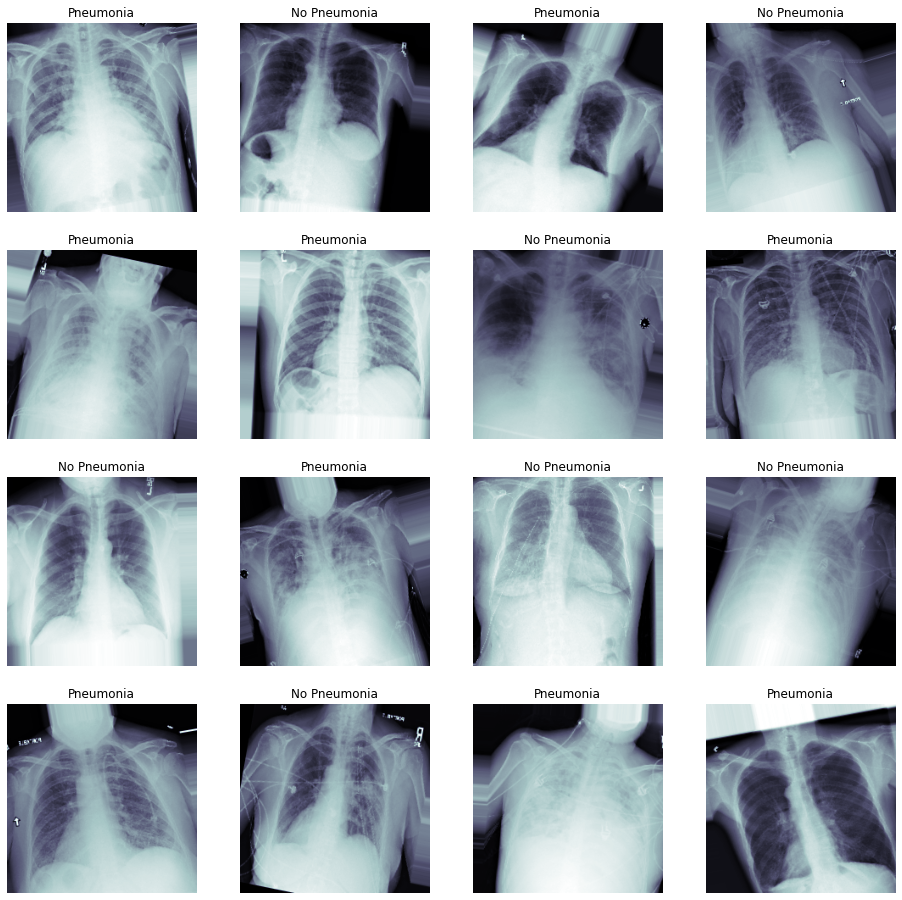

In [11]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y[1]: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [22]:
def load_pretrained_model():
 
    model = VGG16(include_top=True, weights='imagenet')
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)   
    return vgg_model
def build_my_model1():
        
    # Todo
    vgg_model = load_pretrained_model()
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    new_model = Sequential()
    new_model.add(vgg_model)
    new_model.add(Flatten())
    new_model.add(Dense(1, activation='sigmoid'))
    
    return new_model

In [15]:
#model = VGG16(include_top=True, weights='imagenet')
#model.summary()

553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [16]:
#transfer_layer = model.get_layer('block5_pool')
#vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [17]:
#for layer in vgg_model.layers[0:17]:
#    layer.trainable = False

In [18]:
#for layer in vgg_model.layers:
#    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [19]:
#my_model = Sequential()
#my_model.add(vgg_model)
#my_model.add(Flatten())
#my_model.add(Dense(1, activation = 'sigmoid'))
#my_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])


In [20]:
#my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 2,384,897
Non-trainable params: 12,354,880
_________________________________________________________________


In [23]:
new_model.fit_generator(train_gen, 
                       validation_data = (valX, valY),
                       epochs = 5)
                       

NameError: name 'new_model' is not defined

In [91]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [35]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

NameError: name 'my_model' is not defined

In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.preprocessing import binarize
precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)


NameError: name 'valY' is not defined

In [43]:

#N = len(history.history["loss"])

#plt.style.use("ggplot")

#plt.figure()

#plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")

#plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

#plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")

#plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")

#plt.title("Training Loss and Accuracy on Dataset")

#plt.xlabel("Epoch #")

#plt.ylabel("Loss/Accuracy")

#plt.legend(loc="lower left"),


NameError: name 'sklm' is not defined

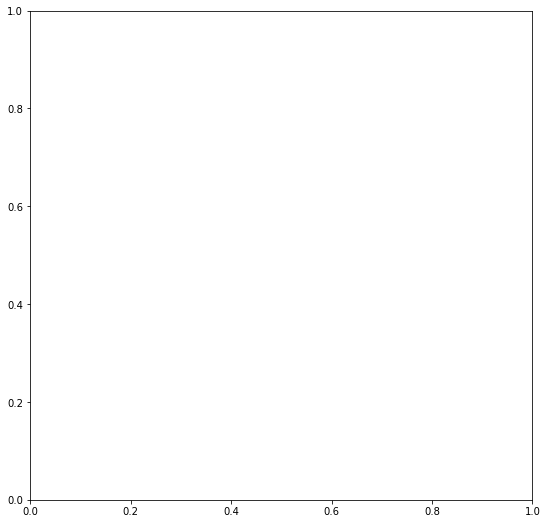

In [44]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = sklm.roc_curve(valY, pred_Y)
c_ax.plot(fpr, tpr, label = '%s (sklm.AUC:%0.2f)'  % ('Pneumonia', sklm.auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

In [45]:
def plot_auc(valY, pred_Y):
    import sklearn.metrics as sklm
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = sklm.roc_curve(valY, pred_Y)
    c_ax.plot(fpr, tpr, label = '%s (sklm.AUC:%0.2f)'  % ('Pneumonia', sklm.auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    print(tpr)
    print(fpr)
    print(thresholds)

    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 

def f1_score_calc(valY, pred_Y):
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
    from sklearn.preprocessing import binarize
    precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
    f1_scores = []
    for i in thresholds:
        f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
        f1_scores.append(f1)
        
    print(f1_scores)
   
    return
    
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left"),
    
    # Todo
    return

In [46]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [47]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.


IndexError: invalid index to scalar variable.

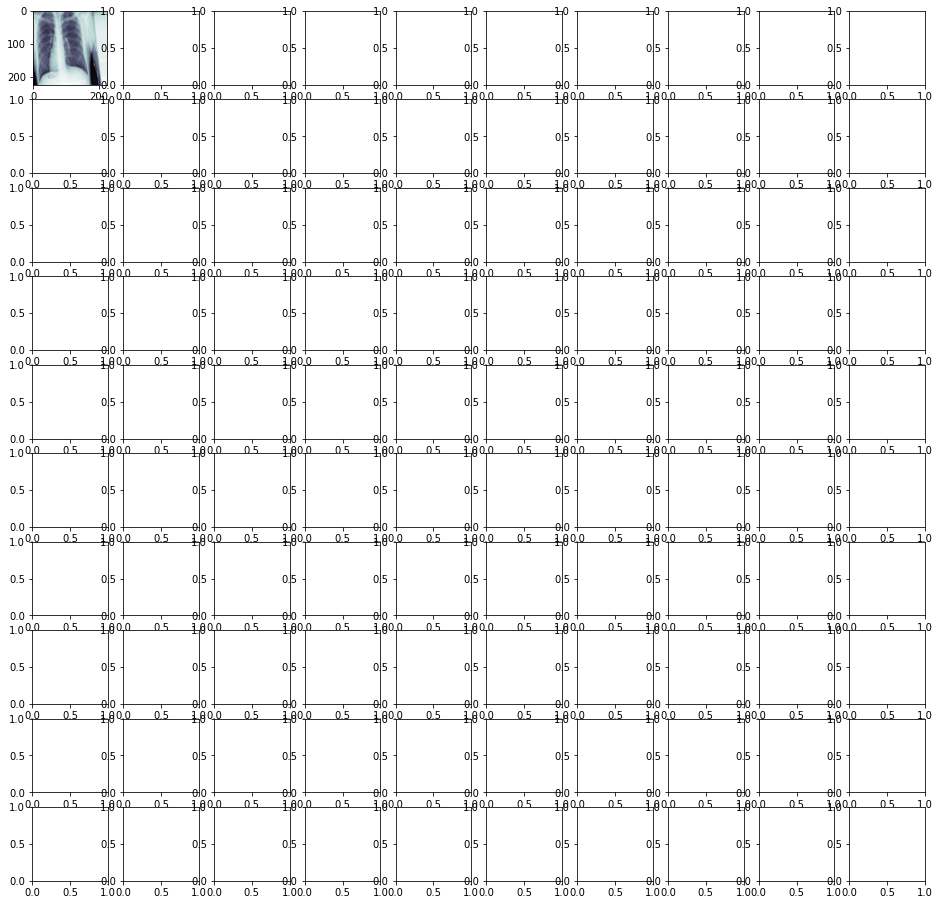

In [189]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y[1]: 
         if pred_Y==1 > 0.515:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > 0.515: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)